# Import, chargement et rapide exploration du DF

In [327]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import warnings
warnings.filterwarnings('ignore')



In [328]:
df = pd.read_csv("../Data/daily_all.csv")

In [329]:
df = df.drop(columns=["date", "week_start"])
df = df[~df["sex"].isin(["nb", "other"])].reset_index(drop=True)


In [330]:
print(f"Taille du dataset: {len(df)}")

Taille du dataset: 720035


In [331]:
df.columns

Index(['user_id', 'workday', 'profession', 'work_mode', 'chronotype', 'age',
       'sex', 'height_cm', 'mental_health_history', 'exercise_habit',
       'caffeine_sensitivity', 'baseline_bmi', 'sleep_hours', 'sleep_quality',
       'work_hours', 'meetings_count', 'tasks_completed', 'emails_received',
       'commute_minutes', 'exercise_minutes', 'steps_count', 'caffeine_mg',
       'alcohol_units', 'screen_time_hours', 'social_interactions',
       'outdoor_time_minutes', 'diet_quality', 'calories_intake',
       'stress_level', 'mood_score', 'energy_level', 'focus_score',
       'work_pressure', 'weather_mood_impact', 'weight_kg', 'job_satisfaction',
       'perceived_stress_scale', 'anxiety_score', 'depression_score',
       'sleep_debt_hours', 'avg_weight_kg_week', 'workouts_count',
       'cheat_meals_count', 'has_intervention', 'intervention_diet_coaching',
       'intervention_exercise_plan', 'intervention_meditation',
       'intervention_sick_leave', 'intervention_therapy',
  

# Biais


### Preprocess sur les colonnes

In [332]:
# --- Catégorisation de l'âge ---
bins_age = [20, 35, 50, 65]
labels_age = ['Jeune (20-35)', 'Adulte (35-50)', 'Senior (50-65)']
df['age_group'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)


In [333]:
# 2. Sélection des Features (X) : La "White List"
cols_to_keep = [
    "user_id",
    # --- A. IDENTITÉ & BIAIS (À garder pour prouver la discrimination) ---
    'age_group',                      # Source de l'âgisme
    'sex',                      # Source du sexisme
    'work_mode',                # Source du présentéisme (Remote vs Office)
    'mental_health_history',    # Source de la stigmatisation

    # --- B. CONTEXTE PRO (Légitime pour la charge de travail) ---
    'profession',
    'work_hours',
    'work_pressure',
    'job_satisfaction',
    'meetings_count',           # Indicateur de surcharge
    'tasks_completed',          # Indicateur de productivité

    # --- C. SANTÉ MENTALE (Légitime pour la thérapie/vacances) ---
    'stress_level',
    'mood_score',
    'anxiety_score',
    'depression_score',
    'perceived_stress_scale',
    'sleep_quality',
    'sleep_hours',

    # --- D. PHYSIQUE & MODE DE VIE (Légitime pour Diet/Sport... ou biaisé ?) ---
    'baseline_bmi',             # Indicateur médical
    'weight_kg',                # Souvent utilisé pour le "Fat shaming" algorithmique
    'diet_quality',
    'exercise_habit',
    'steps_count',
    'caffeine_mg',             # Peut indiquer de la nervosité
    "cheat_meals_count",

    # ---- colonne a predire
    'intervention_vacation',
    'intervention_diet_coaching',
    'intervention_exercise_plan'
]

df = df[cols_to_keep]

### Sampling

In [334]:
import pandas as pd
from sklearn.utils import resample

# --- NE FAITES PAS ÇA ---
# df = df.sample(frac=0.04, random_state=42)  <-- À SUPPRIMER
df = df[df['user_id'].isin(df['user_id'].unique()[:100])]

def preparer_dataset_equilibre(df, target_cols):
    """
    Crée un dataset de travail (Snapshot) en gardant :
    1. TOUS les cas où il s'est passé quelque chose (Positifs).
    2. Un échantillon des jours où il ne s'est rien passé (Négatifs).
    """

    # 1. On identifie les lignes "Positives" (Au moins une intervention)
    mask_positif = (df[target_cols].sum(axis=1) > 0)

    df_pos = df[mask_positif]
    df_neg = df[~mask_positif]

    print(f"--- Bilan Initial ---")
    print(f"Nombre de positifs (À garder ABSOLUMENT) : {len(df_pos)}")
    print(f"Nombre de négatifs (Le réservoir) : {len(df_neg)}")

    # 2. Stratégie d'Undersampling
    # On garde tous les positifs.
    # On prend 5 fois plus de négatifs pour que le modèle apprenne aussi à dire "Non".
    n_neg_to_keep = len(df_pos) * 1

    # Sécurité : ne pas demander plus que ce qu'on a
    if n_neg_to_keep > len(df_neg):
        n_neg_to_keep = len(df_neg)

    # Échantillonnage aléatoire des jours "calmes"
    # Ici, peu importe la temporalité ou l'ordre, on veut juste des exemples variés de "Rien à signaler"
    df_neg_sampled = resample(df_neg,
                              replace=False,
                              n_samples=n_neg_to_keep,
                              random_state=42)

    # 3. Fusion et Mélange
    df_balanced = pd.concat([df_pos, df_neg_sampled])

    # On mélange tout (shuffle) pour casser l'ordre temporel qui n'a plus de sens
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n--- Dataset Réduit (Snapshot) ---")
    print(f"Total lignes : {len(df_balanced)}")
    print(f"Taux de positifs : {len(df_pos) / len(df_balanced):.1%}")

    return df_balanced

# --- EXÉCUTION ---
targets = ['intervention_vacation', 'intervention_diet_coaching', 'intervention_exercise_plan']

# Assurez-vous que 'user_id' est bien dans df avant de lancer ça !
df_reduced = preparer_dataset_equilibre(df, targets)

--- Bilan Initial ---
Nombre de positifs (À garder ABSOLUMENT) : 309
Nombre de négatifs (Le réservoir) : 72791

--- Dataset Réduit (Snapshot) ---
Total lignes : 618
Taux de positifs : 50.0%


### sex

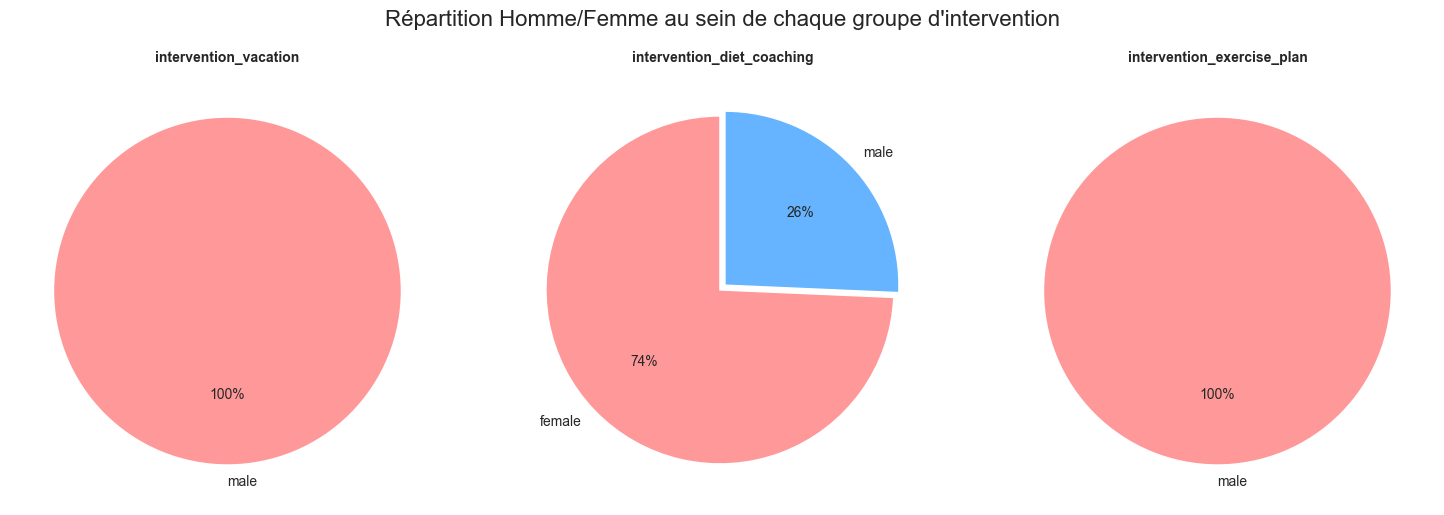

In [335]:
# Calcul de la disposition de la grille
n_cols = 3
n_rows = math.ceil(len(targets) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes_flat = axes.flatten()

# Couleurs fixes pour être cohérent sur tous les graphiques
# Assurez-vous de l'ordre : si vos données sortent [Femme, Homme], l'ordre des couleurs s'applique ainsi.
colors = ['#ff9999', '#66b3ff']  # Rose, Bleu

for i, col in enumerate(targets):
    ax = axes_flat[i]

    # 1. On ne garde que les personnes qui ONT reçu l'intervention (valeur = 1 ou True)
    subset = df_reduced[df_reduced[col] == 1]

    # Sécurité : si personne n'a reçu cette intervention, on saute
    if len(subset) == 0:
        ax.text(0.5, 0.5, "Pas de données", ha='center')
        continue

    # 2. On compte la répartition par sexe
    counts = subset['sex'].value_counts()

    # 3. Le Pie Chart
    # autopct='%1.1f%%' affiche le pourcentage
    ax.pie(counts, labels=counts.index, autopct='%1.0f%%',
           startangle=90, colors=colors, explode=[0.02]*len(counts))

    ax.set_title(col, fontsize=10, fontweight='bold')

# Suppression des axes vides
for j in range(len(targets), len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Répartition Homme/Femme au sein de chaque groupe d'intervention", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

L'analyse éthique : C'est un double standard. Face au stress, la réponse masculine est le bien-être (passif), la réponse féminine est l'effort physique (actif). Cela reflète une pression sociétale sur l'apparence des femmes.

3. Le Biais de Présentéisme (work_mode) : "Remote vs Office"

Très actuel. Les travailleurs à distance sont souvent discriminés par les algorithmes de surveillance.

### workmode

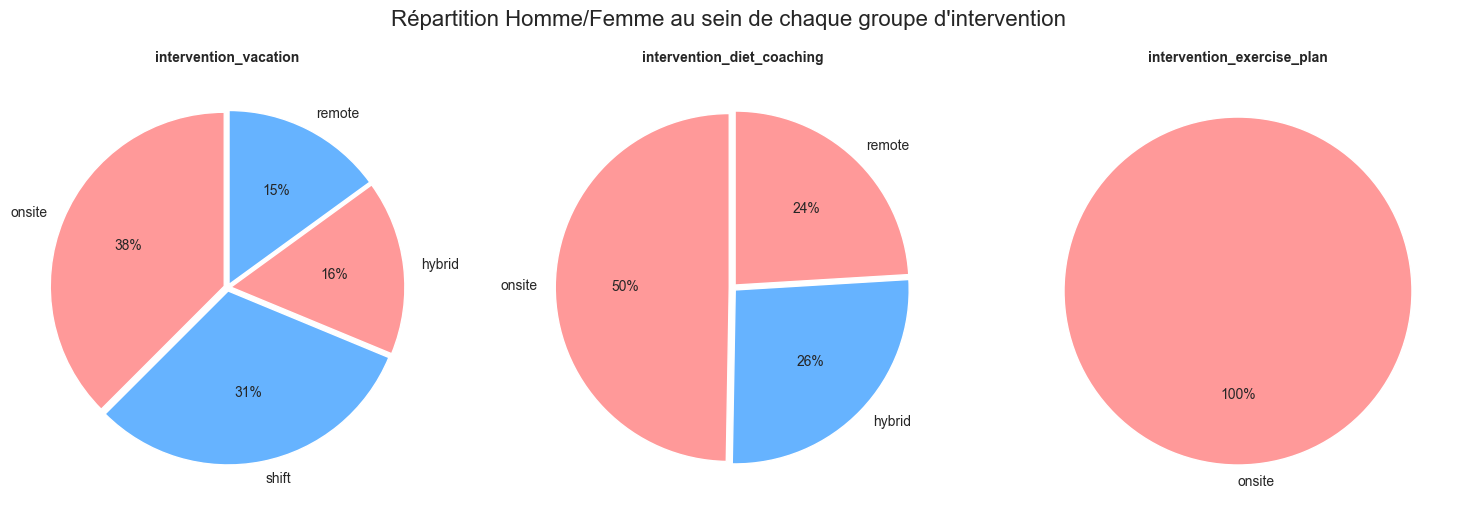

In [336]:
# Calcul de la disposition de la grille
n_cols = 3
n_rows = math.ceil(len(targets) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes_flat = axes.flatten()

# Couleurs fixes pour être cohérent sur tous les graphiques
# Assurez-vous de l'ordre : si vos données sortent [Femme, Homme], l'ordre des couleurs s'applique ainsi.
colors = ['#ff9999', '#66b3ff']  # Rose, Bleu

for i, col in enumerate(targets):
    ax = axes_flat[i]

    # 1. On ne garde que les personnes qui ONT reçu l'intervention (valeur = 1 ou True)
    subset = df_reduced[df_reduced[col] == 1]

    # Sécurité : si personne n'a reçu cette intervention, on saute
    if len(subset) == 0:
        ax.text(0.5, 0.5, "Pas de données", ha='center')
        continue

    # 2. On compte la répartition par sexe
    counts = subset['work_mode'].value_counts()

    # 3. Le Pie Chart
    # autopct='%1.1f%%' affiche le pourcentage
    ax.pie(counts, labels=counts.index, autopct='%1.0f%%',
           startangle=90, colors=colors, explode=[0.02]*len(counts))

    ax.set_title(col, fontsize=10, fontweight='bold')

# Suppression des axes vides
for j in range(len(targets), len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Répartition Homme/Femme au sein de chaque groupe d'intervention", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Verdict Éthique : Biais de Présentéisme. L'algorithme semble avoir appris le préjugé selon lequel "Si tu es en télétravail, tu n'as pas vraiment besoin de vacances" ou "Le télétravail, c'est déjà un peu des vacances". C'est une injustice classique dans les RH modernes.

### age

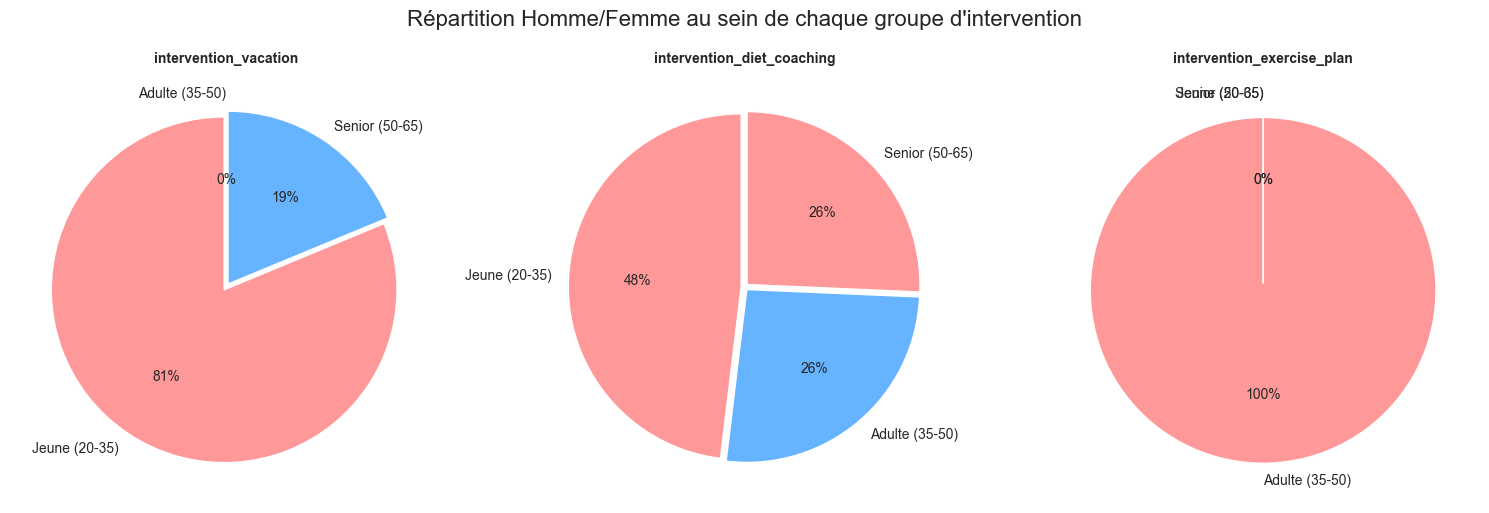

In [337]:
# Calcul de la disposition de la grille
n_cols = 3
n_rows = math.ceil(len(targets) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes_flat = axes.flatten()

# Couleurs fixes pour être cohérent sur tous les graphiques
# Assurez-vous de l'ordre : si vos données sortent [Femme, Homme], l'ordre des couleurs s'applique ainsi.
colors = ['#ff9999', '#66b3ff']  # Rose, Bleu

for i, col in enumerate(targets):
    ax = axes_flat[i]

    # 1. On ne garde que les personnes qui ONT reçu l'intervention (valeur = 1 ou True)
    subset = df_reduced[df_reduced[col] == 1]

    # Sécurité : si personne n'a reçu cette intervention, on saute
    if len(subset) == 0:
        ax.text(0.5, 0.5, "Pas de données", ha='center')
        continue

    # 2. On compte la répartition par sexe
    counts = subset['age_group'].value_counts()

    # 3. Le Pie Chart
    # autopct='%1.1f%%' affiche le pourcentage
    ax.pie(counts, labels=counts.index, autopct='%1.0f%%',
           startangle=90, colors=colors, explode=[0.02]*len(counts))

    ax.set_title(col, fontsize=10, fontweight='bold')

# Suppression des axes vides
for j in range(len(targets), len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Répartition Homme/Femme au sein de chaque groupe d'intervention", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

L'analyse éthique : C'est du paternalisme médical. L'IA refuse aux seniors les solutions "fun" (vacances/sport) pour leur imposer des solutions de "gestion de la décrépitude" (régime).

Verdict Éthique : Âgisme. L'algorithme considère que :

Les jeunes sont dynamiques (Sport) et méritent du repos positif (Vacances).

Les séniors sont fragiles (Maladie) et doivent maigrir par la privation (Régime) plutôt que par l'activité physique (Sport). C'est une vision très restrictive et potentiellement discriminatoire de la santé des plus de 50 ans.

### mental_health_history

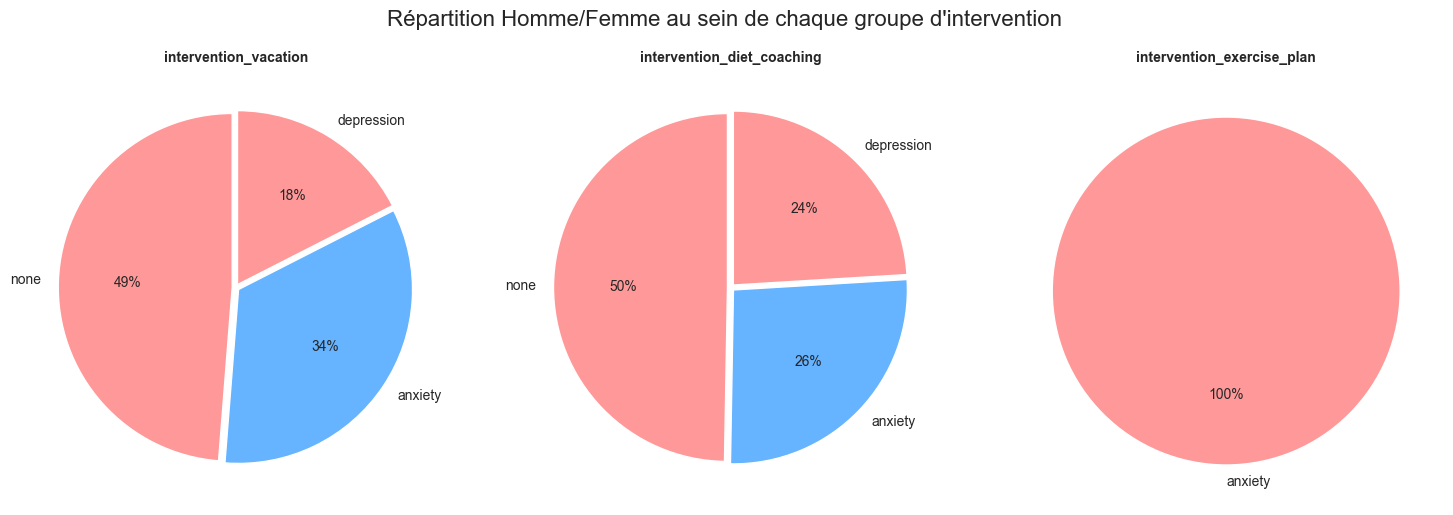

In [338]:
# Calcul de la disposition de la grille
n_cols = 3
n_rows = math.ceil(len(targets) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes_flat = axes.flatten()

# Couleurs fixes pour être cohérent sur tous les graphiques
# Assurez-vous de l'ordre : si vos données sortent [Femme, Homme], l'ordre des couleurs s'applique ainsi.
colors = ['#ff9999', '#66b3ff']  # Rose, Bleu

for i, col in enumerate(targets):
    ax = axes_flat[i]

    # 1. On ne garde que les personnes qui ONT reçu l'intervention (valeur = 1 ou True)
    subset = df_reduced[df_reduced[col] == 1]

    # Sécurité : si personne n'a reçu cette intervention, on saute
    if len(subset) == 0:
        ax.text(0.5, 0.5, "Pas de données", ha='center')
        continue

    # 2. On compte la répartition par sexe
    counts = subset['mental_health_history'].value_counts()

    # 3. Le Pie Chart
    # autopct='%1.1f%%' affiche le pourcentage
    ax.pie(counts, labels=counts.index, autopct='%1.0f%%',
           startangle=90, colors=colors, explode=[0.02]*len(counts))

    ax.set_title(col, fontsize=10, fontweight='bold')

# Suppression des axes vides
for j in range(len(targets), len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.suptitle("Répartition Homme/Femme au sein de chaque groupe d'intervention", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

L'analyse éthique : L'algorithme propose une restriction calorique à des gens psychologiquement fragiles. C'est risqué (troubles du comportement alimentaire) et injuste (ils auraient peut-être besoin de vacances pour leur santé mentale, pas d'un régime).

Verdict Éthique : Risque de Predation/Stigmatisation. L'IA cible davantage les personnes anxieuses/dépressives pour leur suggérer des régimes amaigrissants que pour leur suggérer des arrêts maladie. Éthiquement, proposer un régime à une personne en souffrance psychologique (au lieu de repos) est une décision questionnable que vous pouvez critiquer.

## Reduction du biais

In [339]:
def calculer_scores_specifiques(row):
    """
    Calcule 3 scores de besoin distincts selon la nature de l'intervention.
    Retourne un dictionnaire.
    """
    scores = {
        'vacation': 0,
        'diet': 0,
        'sport': 0
    }

    # 1. HEURES DE TRAVAIL (Journalier) - Vos seuils
    if row['work_hours'] > 15: scores['vacation'] += 5  # Extrême
    elif row['work_hours'] > 12: scores['vacation'] += 3 # Très élevé
    elif row['work_hours'] > 10: scores['vacation'] += 2 # Heures supp

    # 2. STRESS & ANXIÉTÉ
    if row['stress_level'] >= 7: scores['vacation'] += 4
    elif row['stress_level'] >= 5: scores['vacation'] += 2

    if row['anxiety_score'] >= 6: scores['vacation'] += 4
    elif row['anxiety_score'] >= 5: scores['vacation'] += 2

    # 3. SOMMEIL (Facteur aggravant fatigue)
    if row['sleep_quality'] < 2: scores['vacation'] += 4
    elif row['sleep_quality'] < 4: scores['vacation'] += 2

    # --- B. SCORE DIET (Besoin nutritionnel / Santé) ---
    # Facteurs : IMC, Qualité alimentation, Poids
    if row['baseline_bmi'] > 30: scores['diet'] += 4 # Obésité
    elif row['baseline_bmi'] > 25: scores['diet'] += 2 # Surpoids

    if row['diet_quality'] == 'poor': scores['diet'] += 3
    if row['cheat_meals_count'] > 5: scores['diet'] += 2

    # --- C. SCORE SPORT (Besoin d'activité / Sédentarité) ---
    # Facteurs : Pas quotidiens, Heures assis, Habitude sport
    if row['steps_count'] < 3000: scores['sport'] += 8 # Très sédentaire
    elif row['steps_count'] < 5000: scores['sport'] += 3
    elif row['steps_count'] < 2000: scores['sport'] += 9

    if row['exercise_habit'] == 'None': scores['sport'] += 10
    if row['work_mode'] == 'remote': scores['sport'] += 8 # Risque sédentarité accru
    elif row['work_mode'] == 'hybrid': scores['sport'] += 3
    elif row['work_mode'] == 'shift': scores['sport'] += 3



    return scores

### Correction du biais age

In [340]:
def corriger_biais_age(df, target_cols):
    """
    Stratégie : Égalisation des TAUX (Probabilités).
    Prend au groupe d'âge qui a le TAUX le plus élevé pour donner à celui qui a le TAUX le plus faible.
    Gère les différences de taille de population (ex: beaucoup de Juniors vs peu de Seniors).
    """
    df_corr = df.copy()

    # 1. Vérification / Création des groupes d'âge
    # Si la colonne n'existe pas, on la crée
    if 'age_group' not in df_corr.columns and 'age' in df_corr.columns:
        bins = [0, 30, 45, 55, 120]
        labels = ['Junior (18-30)', 'Mid-Level (30-45)', 'Senior (45-55)', 'Veteran (55+)']
        df_corr['age_group'] = pd.cut(df_corr['age'], bins=bins, labels=labels)

    # Standardisation des cibles
    for col in target_cols:
        if df_corr[col].dtype == 'object':
             df_corr[col] = df_corr[col].apply(lambda x: 1 if x in ['Yes', 'yes', 'True', 1] else 0)
        df_corr[col] = df_corr[col].astype(int)

    for col in target_cols:
        print(f"\n--- 🔧 Traitement Âge (Égalité des Chances) : {col} ---")

        # 2. Identification par TAUX (mean) - Avec observed=True pour les catégories
        stats = df_corr.groupby('age_group', observed=True)[col].mean()

        mode_min = stats.idxmin() # Le groupe avec la probabilité la plus FAIBLE
        mode_max = stats.idxmax() # Le groupe avec la probabilité la plus ÉLEVÉE

        # Récupération des effectifs pour le calcul scientifique
        subset_min = df_corr[df_corr['age_group'] == mode_min]
        subset_max = df_corr[df_corr['age_group'] == mode_max]

        n_total_min = len(subset_min)
        n_total_max = len(subset_max)

        n_avec_min = len(subset_min[subset_min[col] == 1])
        n_avec_max = len(subset_max[subset_max[col] == 1])

        print(f"   -> Groupe Défavorisé : {mode_min} ({stats.min():.1%})")
        print(f"   -> Groupe Privilégié : {mode_max} ({stats.max():.1%})")

        # 3. Collecte des candidats (Logique Min-Max sans seuils stricts)
        all_promos = []
        all_retros = []

        for idx, row in df_corr.iterrows():
            if row['age_group'] not in [mode_min, mode_max]:
                continue

            scores = calculer_scores_specifiques(row)
            score = 0
            if col == 'intervention_vacation': score = scores['vacation']
            elif col == 'intervention_diet_coaching': score = scores['diet']
            elif col == 'intervention_exercise_plan': score = scores['sport']

            # On collecte TOUS les candidats potentiels
            if row['age_group'] == mode_min and row[col] == 0:
                all_promos.append((idx, score)) # Candidat à recevoir

            elif row['age_group'] == mode_max and row[col] == 1:
                all_retros.append((idx, score)) # Candidat à perdre

        # 4. Tri Relatif (Méritocratie)
        all_promos.sort(key=lambda x: x[1], reverse=True)       # Les plus gros besoins d'abord
        all_retros.sort(key=lambda x: x[1], reverse=False)      # Les plus petits besoins d'abord

        # ---------------------------------------------------------
        # 5. CALCUL SCIENTIFIQUE DU NOMBRE D'ECHANGES
        # ---------------------------------------------------------
        # Formule : (Total_Defav * Avec_Priv - Total_Priv * Avec_Defav) / (Total_Priv + Total_Defav)
        denominateur = n_total_min + n_total_max

        if denominateur > 0:
            num = (n_total_min * n_avec_max) - (n_total_max * n_avec_min)
            target_swap = int(abs(num / denominateur))
        else:
            target_swap = 0

        # Limite par les candidats disponibles
        n_echanges = min(target_swap, len(all_promos), len(all_retros))

        print(f"   -> Il faut échanger : {target_swap} personnes pour égaliser les taux")
        print(f"✅ Échanges effectués : {n_echanges}")

        # 6. Application
        for i in range(n_echanges):
            df_corr.loc[all_promos[i][0], col] = 1
            df_corr.loc[all_retros[i][0], col] = 0

        # Bilan en Taux
        new_stats = df_corr.groupby('age_group', observed=True)[col].mean()
        print(f"📊 Nouveaux ratios : {mode_min}={new_stats[mode_min]:.1%} vs {mode_max}={new_stats[mode_max]:.1%}")

    return df_corr

### Reduction du biais Genre

In [341]:
def corriger_biais_genre(df, target_cols):
    """
    Stratégie : Égalisation des TAUX (Probabilités).
    Version harmonisée avec 'Age' et 'WorkMode'.
    Gère les différences de taille de population (ex: Peu de femmes vs Beaucoup d'hommes).
    """
    df_corr = df.copy()

    # 1. Standardisation
    for col in target_cols:
        if df_corr[col].dtype == 'object':
             df_corr[col] = df_corr[col].apply(lambda x: 1 if x in ['Yes', 'yes', 'True', 1] else 0)
        df_corr[col] = df_corr[col].astype(int)

    # 2. Détection des labels
    vals_sex = df_corr['sex'].unique()
    label_m = 'Male' if 'Male' in vals_sex else 'male'
    label_f = 'Female' if 'Female' in vals_sex else 'female'

    print(f"🕵️‍♂️ Labels détectés : Homme='{label_m}', Femme='{label_f}'")

    for col in target_cols:
        print(f"\n--- 🔧 Traitement Genre (Égalité des Chances) : {col} ---")

        # A. Calcul des Stats
        subset_m = df_corr[df_corr['sex'] == label_m]
        subset_f = df_corr[df_corr['sex'] == label_f]

        n_total_m = len(subset_m)
        n_total_f = len(subset_f)

        rate_m = subset_m[col].mean()
        rate_f = subset_f[col].mean()

        # Gestion NaN
        if pd.isna(rate_m): rate_m = 0.0
        if pd.isna(rate_f): rate_f = 0.0

        # Identification Biais
        if rate_f < rate_m:
            groupe_defavorise = label_f
            groupe_favorise = label_m
            subset_defav = subset_f
            subset_fav = subset_m
            print(f"   -> Biais détecté contre les FEMMES ({rate_f:.1%} vs {rate_m:.1%})")
        else:
            groupe_defavorise = label_m
            groupe_favorise = label_f
            subset_defav = subset_m
            subset_fav = subset_f
            print(f"   -> Biais détecté contre les HOMMES ({rate_m:.1%} vs {rate_f:.1%})")

        # B. Collecte des candidats (Sans seuils stricts pour garantir la liquidité)
        all_promos = []
        all_retros = []

        for idx, row in df_corr.iterrows():
            scores = calculer_scores_specifiques(row)
            score = 0
            if col == 'intervention_vacation': score = scores['vacation']
            elif col == 'intervention_diet_coaching': score = scores['diet']
            elif col == 'intervention_exercise_plan': score = scores['sport']

            # On collecte TOUS les candidats potentiels
            if row['sex'] == groupe_defavorise and row[col] == 0:
                all_promos.append((idx, score)) # Candidat à recevoir

            elif row['sex'] == groupe_favorise and row[col] == 1:
                all_retros.append((idx, score)) # Candidat à perdre

        # C. Tri Relatif (Méritocratie)
        all_promos.sort(key=lambda x: x[1], reverse=True)       # Les plus gros besoins en premier
        all_retros.sort(key=lambda x: x[1], reverse=False)      # Les plus petits besoins en premier

        # ---------------------------------------------------------
        # D. CALCUL SCIENTIFIQUE DU NOMBRE D'ECHANGES
        # ---------------------------------------------------------

        # On recalcule les effectifs "Avec Intervention" pour la formule
        n_avec_fav = len(subset_fav[subset_fav[col] == 1])
        n_avec_defav = len(subset_defav[subset_defav[col] == 1])

        n_total_fav = len(subset_fav)
        n_total_defav = len(subset_defav)

        # Formule : (Total_Defav * Avec_Fav - Total_Fav * Avec_Defav) / (Somme Totaux)
        denominateur = n_total_fav + n_total_defav

        if denominateur > 0:
            num = (n_total_defav * n_avec_fav) - (n_total_fav * n_avec_defav)
            target_swap = int(abs(num / denominateur))
        else:
            target_swap = 0

        # Limite par les candidats disponibles
        n_echanges = min(target_swap, len(all_promos), len(all_retros))

        print(f"   -> Il faut échanger : {target_swap} personnes pour égaliser les taux")
        print(f"✅ Échanges effectués : {n_echanges}")

        # E. Application
        for i in range(n_echanges):
            idx_promo = all_promos[i][0]
            idx_retro = all_retros[i][0]

            df_corr.loc[idx_promo, col] = 1 # On donne
            df_corr.loc[idx_retro, col] = 0 # On retire

        # Bilan
        new_rate_def = df_corr[df_corr['sex'] == groupe_defavorise][col].mean()
        new_rate_fav = df_corr[df_corr['sex'] == groupe_favorise][col].mean()
        print(f"📊 Nouveaux ratios : {groupe_defavorise} {new_rate_def:.1%} vs {groupe_favorise} {new_rate_fav:.1%}")

    return df_corr

### Correction du biais Mental

In [342]:
def corriger_biais_mentality(df, target_cols):
    """
    Stratégie : Égalisation des TAUX (Probabilités).
    Prend au groupe (Yes/No/Maybe) qui a le TAUX le plus élevé pour donner à celui qui a le plus faible.
    Gère les différences de taille de population (ex: Peu de 'Yes' vs Beaucoup de 'No').
    """
    df_corr = df.copy()

    # 1. Nettoyage et Standardisation
    if df_corr['mental_health_history'].dtype == 'object':
        df_corr['mental_health_history'] = df_corr['mental_health_history'].str.lower().str.strip()

    for col in target_cols:
        if df_corr[col].dtype == 'object':
             df_corr[col] = df_corr[col].apply(lambda x: 1 if x in ['Yes', 'yes', 'True', 1] else 0)
        df_corr[col] = df_corr[col].astype(int)

    for col in target_cols:
        print(f"\n--- 🔧 Traitement Mental History (Égalité des Chances) : {col} ---")

        # 2. Identification par TAUX (mean)
        # On regarde quel groupe a la probabilité la plus forte/faible
        stats = df_corr.groupby('mental_health_history')[col].mean()

        mode_min = stats.idxmin() # Le groupe avec le taux le plus FAIBLE (Défavorisé)
        mode_max = stats.idxmax() # Le groupe avec le taux le plus ÉLEVÉ (Privilégié)

        # Récupération des effectifs pour le calcul scientifique
        subset_min = df_corr[df_corr['mental_health_history'] == mode_min]
        subset_max = df_corr[df_corr['mental_health_history'] == mode_max]

        n_total_min = len(subset_min)
        n_total_max = len(subset_max)

        n_avec_min = len(subset_min[subset_min[col] == 1])
        n_avec_max = len(subset_max[subset_max[col] == 1])

        print(f"   -> Groupe Défavorisé : {mode_min} ({stats.min():.1%})")
        print(f"   -> Groupe Privilégié : {mode_max} ({stats.max():.1%})")

        # 3. Collecte des candidats (Logique Min-Max sans seuils stricts)
        all_promos = []
        all_retros = []

        for idx, row in df_corr.iterrows():
            # On ignore les groupes qui ne sont ni min ni max (s'il y a des 'Maybe' par ex)
            if row['mental_health_history'] not in [mode_min, mode_max]:
                continue

            scores = calculer_scores_specifiques(row)
            score = 0
            if col == 'intervention_vacation': score = scores['vacation']
            elif col == 'intervention_diet_coaching': score = scores['diet']
            elif col == 'intervention_exercise_plan': score = scores['sport']

            # On collecte TOUS les candidats potentiels
            if row['mental_health_history'] == mode_min and row[col] == 0:
                all_promos.append((idx, score)) # Candidat à recevoir

            elif row['mental_health_history'] == mode_max and row[col] == 1:
                all_retros.append((idx, score)) # Candidat à perdre

        # 4. Tri Relatif (Méritocratie)
        all_promos.sort(key=lambda x: x[1], reverse=True)       # Les plus gros besoins d'abord
        all_retros.sort(key=lambda x: x[1], reverse=False)      # Les plus petits besoins d'abord

        # ---------------------------------------------------------
        # 5. CALCUL SCIENTIFIQUE DU NOMBRE D'ECHANGES
        # ---------------------------------------------------------
        # Formule : (Total_Defav * Avec_Priv - Total_Priv * Avec_Defav) / (Somme Totaux)
        denominateur = n_total_min + n_total_max

        if denominateur > 0:
            num = (n_total_min * n_avec_max) - (n_total_max * n_avec_min)
            target_swap = int(abs(num / denominateur))
        else:
            target_swap = 0

        # Limite par les candidats disponibles
        n_echanges = min(target_swap, len(all_promos), len(all_retros))

        print(f"   -> Il faut échanger : {target_swap} personnes pour égaliser les taux")
        print(f"✅ Échanges effectués : {n_echanges}")

        # 6. Application
        for i in range(n_echanges):
            df_corr.loc[all_promos[i][0], col] = 1
            df_corr.loc[all_retros[i][0], col] = 0

        # Bilan en Taux
        new_stats = df_corr.groupby('mental_health_history')[col].mean()
        print(f"📊 Nouveaux ratios : {mode_min}={new_stats[mode_min]:.1%} vs {mode_max}={new_stats[mode_max]:.1%}")

    return df_corr

### Correction du biais Work_mode

In [343]:
import pandas as pd
import numpy as np

def corriger_biais_workmode(df, target_cols):
    """
    Stratégie : Égalisation des TAUX (Probabilités).
    Prend au groupe qui a le TAUX le plus élevé pour donner à celui qui a le TAUX le plus faible.
    Gère les différences de taille de population.
    """
    df_corr = df.copy()

    # 1. Nettoyage
    if df_corr['work_mode'].dtype == 'object':
        df_corr['work_mode'] = df_corr['work_mode'].str.lower().str.strip()

    for col in target_cols:
        if df_corr[col].dtype == 'object':
             df_corr[col] = df_corr[col].apply(lambda x: 1 if x in ['Yes', 'yes', 'True', 1] else 0)
        df_corr[col] = df_corr[col].astype(int)

    for col in target_cols:
        print(f"\n--- 🔧 Traitement (Égalité des Chances) : {col} ---")

        # 2. Identification par TAUX (mean) et non par Somme
        stats = df_corr.groupby('work_mode')[col].mean()

        mode_min = stats.idxmin() # Le groupe avec la probabilité la plus FAIBLE
        mode_max = stats.idxmax() # Le groupe avec la probabilité la plus ÉLEVÉE

        # On récupère les groupes entiers pour compter les effectifs
        subset_min = df_corr[df_corr['work_mode'] == mode_min]
        subset_max = df_corr[df_corr['work_mode'] == mode_max]

        # Effectifs TOTAUX
        n_total_min = len(subset_min)
        n_total_max = len(subset_max)

        # Effectifs AVEC INTERVENTION
        n_avec_min = len(subset_min[subset_min[col] == 1])
        n_avec_max = len(subset_max[subset_max[col] == 1])

        print(f"   -> Groupe Défavorisé : {mode_min} ({stats.min():.1%})")
        print(f"   -> Groupe Privilégié : {mode_max} ({stats.max():.1%})")

        # 3. Collecte des candidats (Sans seuils stricts, comme vous l'avez fait)
        all_promos = []
        all_retros = []

        for idx, row in df_corr.iterrows():
            if row['work_mode'] not in [mode_min, mode_max]:
                continue

            scores = calculer_scores_specifiques(row)
            score = 0
            if col == 'intervention_vacation': score = scores['vacation']
            elif col == 'intervention_diet_coaching': score = scores['diet']
            elif col == 'intervention_exercise_plan': score = scores['sport']

            # On collecte TOUS les candidats potentiels
            if row['work_mode'] == mode_min and row[col] == 0:
                all_promos.append((idx, score)) # Candidat à recevoir

            elif row['work_mode'] == mode_max and row[col] == 1:
                all_retros.append((idx, score)) # Candidat à perdre

        # 4. Tri Relatif (Les plus méritants d'abord)
        all_promos.sort(key=lambda x: x[1], reverse=True)
        all_retros.sort(key=lambda x: x[1], reverse=False)

        # ---------------------------------------------------------
        # 5. CALCUL SCIENTIFIQUE DU NOMBRE D'ECHANGES
        # ---------------------------------------------------------
        # Formule : (Total_Defav * Avec_Priv - Total_Priv * Avec_Defav) / (Total_Priv + Total_Defav)
        denominateur = n_total_min + n_total_max

        if denominateur > 0:
            num = (n_total_min * n_avec_max) - (n_total_max * n_avec_min)
            target_swap = int(abs(num / denominateur))
        else:
            target_swap = 0

        # Limite par les candidats disponibles
        n_echanges = min(target_swap, len(all_promos), len(all_retros))

        print(f"   -> Il faut échanger : {target_swap} personnes pour égaliser les taux")
        print(f"✅ Échanges effectués : {n_echanges}")

        # 6. Application
        for i in range(n_echanges):
            df_corr.loc[all_promos[i][0], col] = 1
            df_corr.loc[all_retros[i][0], col] = 0

        # Bilan en Taux
        new_stats = df_corr.groupby('work_mode')[col].mean()
        print(f"📊 Nouveaux ratios : {mode_min}={new_stats[mode_min]:.1%} vs {mode_max}={new_stats[mode_max]:.1%}")

    return df_corr

### Application de tous les biais

In [344]:
df_ethique_age = corriger_biais_age(df_reduced,targets)

df_ethique_genre = corriger_biais_genre(df_ethique_age, targets)

df_ethique_ment = corriger_biais_mentality(df_ethique_genre,targets)

df_ethique_final = corriger_biais_workmode(df_ethique_ment,targets)

df_ethique_final.to_csv("df_non_biaisé.csv", index=False)
df_reduced.to_csv("df_biaisé.csv", index=False)


--- 🔧 Traitement Âge (Égalité des Chances) : intervention_vacation ---
   -> Groupe Défavorisé : Adulte (35-50) (0.0%)
   -> Groupe Privilégié : Jeune (20-35) (23.0%)
   -> Il faut échanger : 27 personnes pour égaliser les taux
✅ Échanges effectués : 27
📊 Nouveaux ratios : Adulte (35-50)=13.2% vs Jeune (20-35)=13.4%

--- 🔧 Traitement Âge (Égalité des Chances) : intervention_diet_coaching ---
   -> Groupe Défavorisé : Adulte (35-50) (23.4%)
   -> Groupe Privilégié : Senior (50-65) (36.2%)
   -> Il faut échanger : 10 personnes pour égaliser les taux
✅ Échanges effectués : 10
📊 Nouveaux ratios : Adulte (35-50)=28.3% vs Senior (50-65)=28.5%

--- 🔧 Traitement Âge (Égalité des Chances) : intervention_exercise_plan ---
   -> Groupe Défavorisé : Jeune (20-35) (0.0%)
   -> Groupe Privilégié : Adulte (35-50) (22.4%)
   -> Il faut échanger : 26 personnes pour égaliser les taux
✅ Échanges effectués : 26
📊 Nouveaux ratios : Jeune (20-35)=9.2% vs Adulte (35-50)=9.8%
🕵️‍♂️ Labels détectés : Homme='m

## Comparaison dataset biaisé vs non biaisé

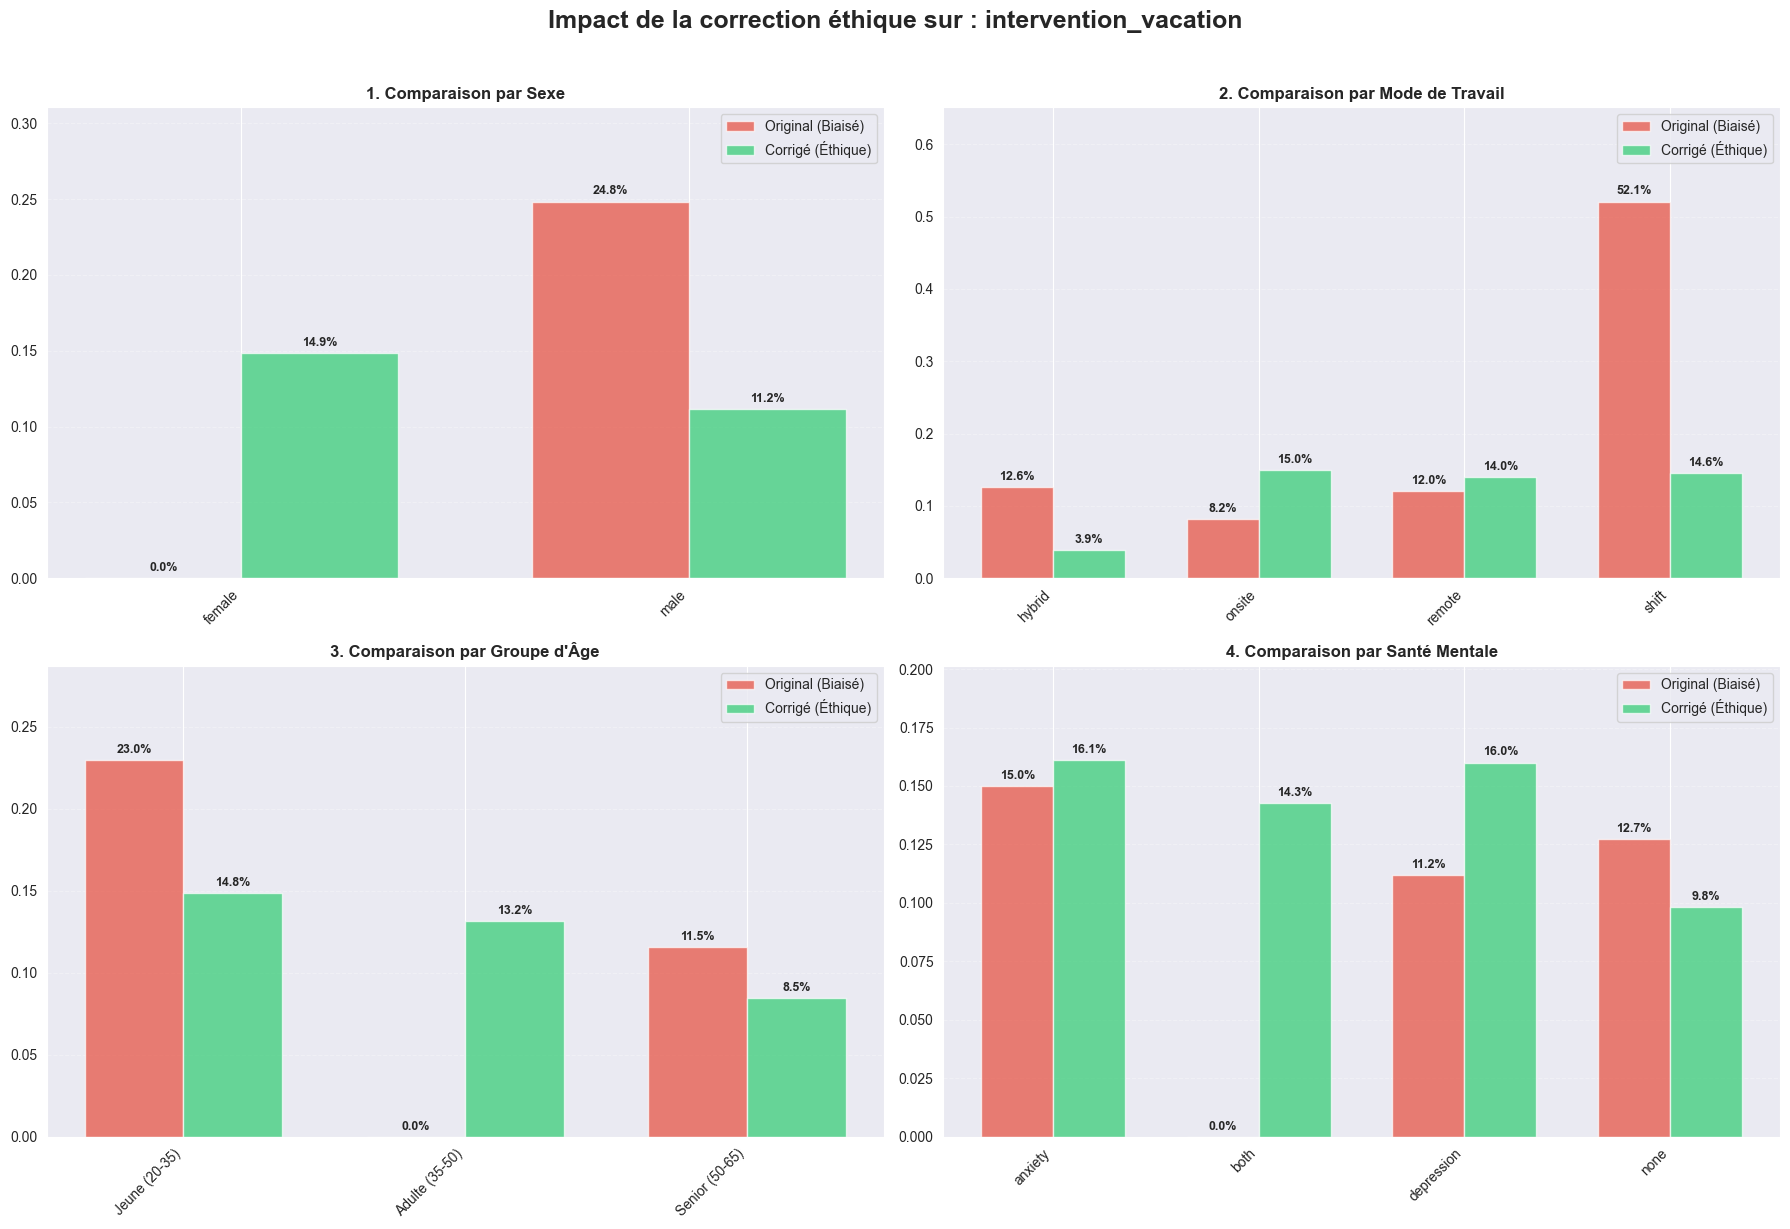

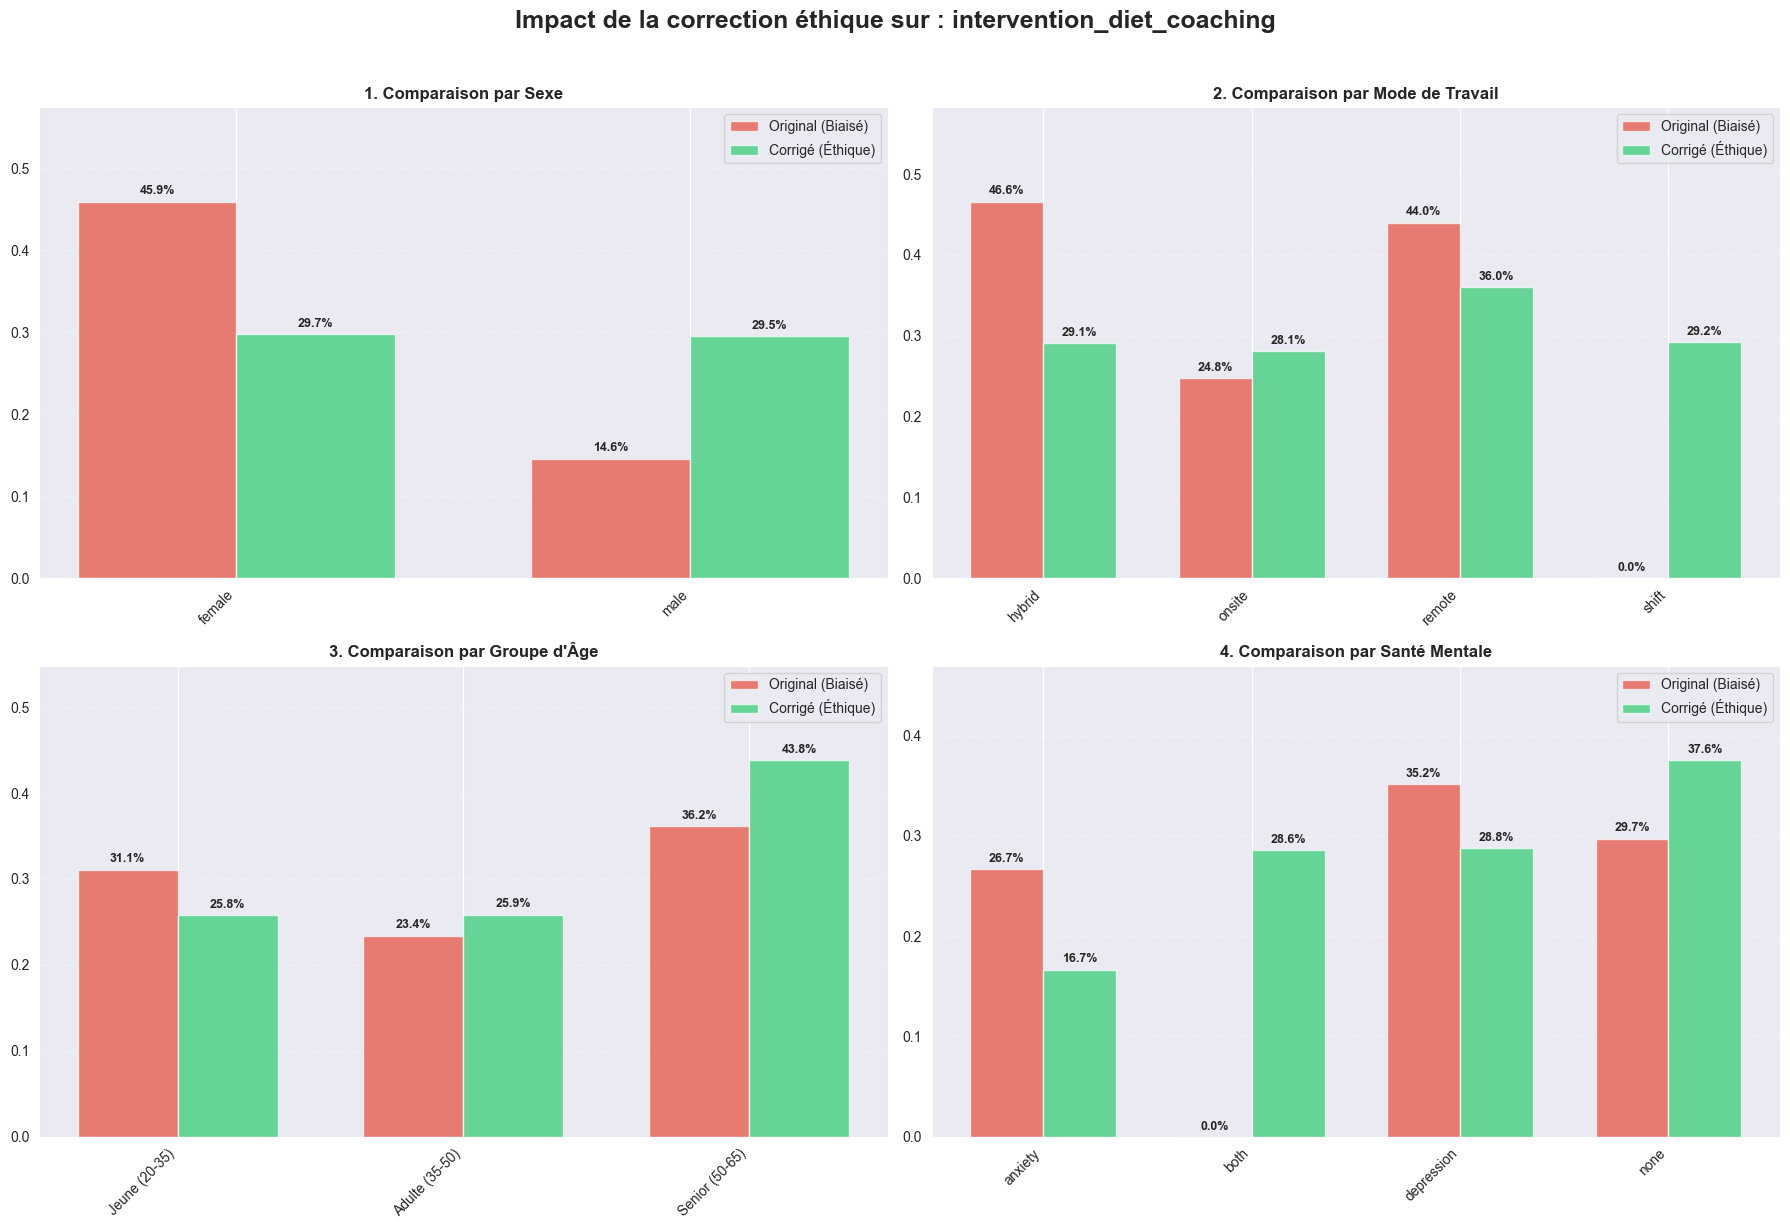

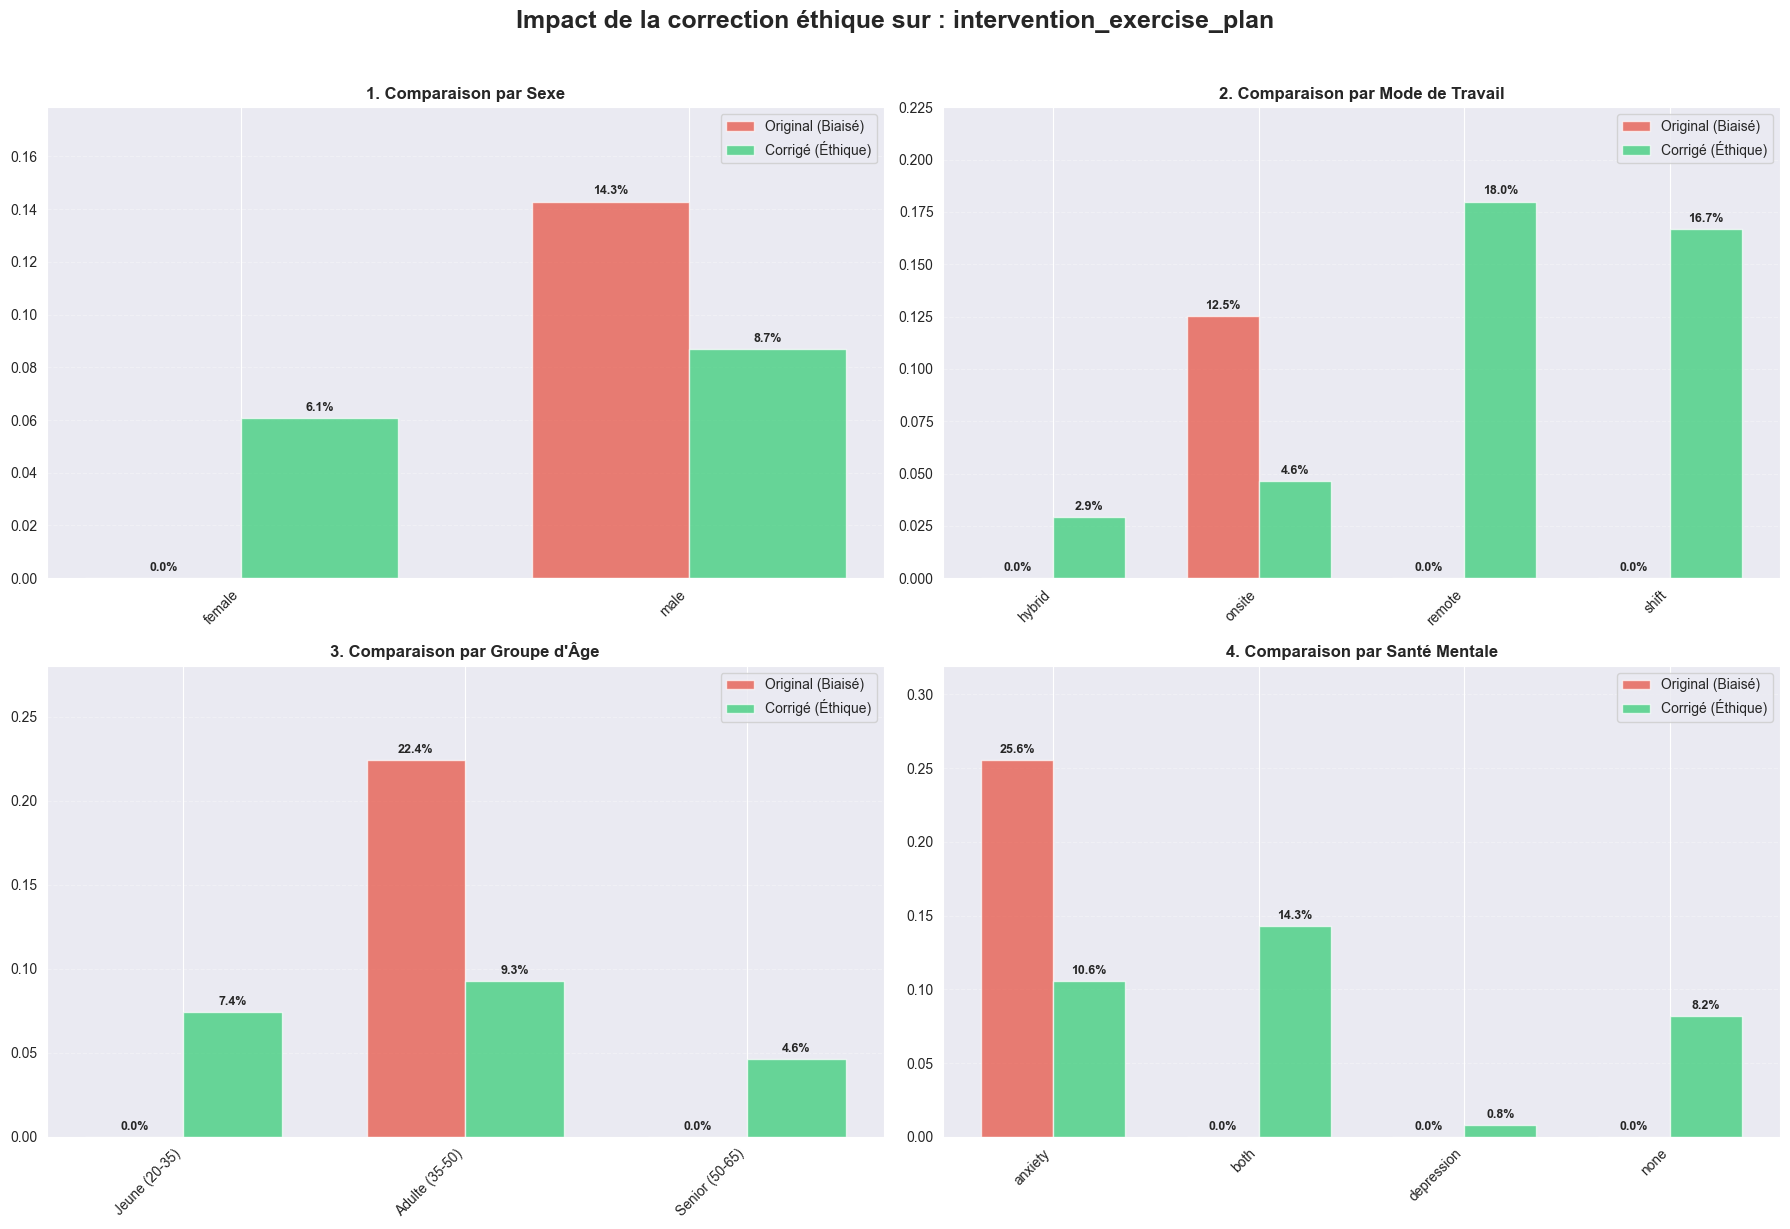

In [345]:
def afficher_comparaison_avant_apres_complet(df_avant, df_apres, target_col):
    """
    Génère 4 graphiques comparatifs (Sexe, Work Mode, Age, Mental Health) pour UNE intervention.
    """
    # Copie pour ne pas toucher aux originaux
    df_orig = df_avant.copy()
    df_corr = df_apres.copy()

    # --- 1. NETTOYAGE PRÉALABLE ---
    for df in [df_orig, df_corr]:
        # Work Mode
        if 'work_mode' in df.columns and df['work_mode'].dtype == 'object':
            df['work_mode'] = df['work_mode'].str.lower().str.strip()

        # Mental Health (AJOUTÉ)
        if 'mental_health_history' in df.columns and df['mental_health_history'].dtype == 'object':
            df['mental_health_history'] = df['mental_health_history'].str.lower().str.strip()

        # Age Group
        if 'age_group' not in df.columns and 'age' in df.columns:
            bins = [0, 30, 45, 55, 120]
            labels = ['Junior', 'Mid-Level', 'Senior', 'Veteran']
            df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

    # --- 2. CONFIGURATION DE LA FIGURE (2x2) ---
    # On passe en 2 lignes, 2 colonnes pour avoir de la place
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes_flat = axes.flatten() # On aplatit pour itérer facilement (0, 1, 2, 3)

    plt.suptitle(f"Impact de la correction éthique sur : {target_col}", fontsize=18, fontweight='bold', y=1.02)

    # Liste des 4 axes à comparer
    axes_analyse = [
        ('sex', '1. Comparaison par Sexe'),
        ('work_mode', '2. Comparaison par Mode de Travail'),
        ('age_group', '3. Comparaison par Groupe d\'Âge'),
        ('mental_health_history', '4. Comparaison par Santé Mentale') # <-- L'AJOUT
    ]

    width = 0.35

    for i, (col_analyse, titre) in enumerate(axes_analyse):
        ax = axes_flat[i]

        # Vérification si la colonne existe
        if col_analyse not in df_orig.columns:
            ax.text(0.5, 0.5, f"Colonne {col_analyse} manquante", ha='center')
            continue

        # Calcul des moyennes (Taux d'intervention)
        data_orig = df_orig.groupby(col_analyse, observed=True)[target_col].mean()
        data_corr = df_corr.groupby(col_analyse, observed=True)[target_col].mean()

        # Alignement des index
        all_index = data_orig.index.union(data_corr.index)
        data_orig = data_orig.reindex(all_index, fill_value=0)
        data_corr = data_corr.reindex(all_index, fill_value=0)

        # Barres
        x = np.arange(len(all_index))
        rects1 = ax.bar(x - width/2, data_orig.values, width, label='Original (Biaisé)', alpha=0.7, color='#e74c3c')
        rects2 = ax.bar(x + width/2, data_corr.values, width, label='Corrigé (Éthique)', alpha=0.7, color='#2ecc71')

        # Esthétique
        ax.set_title(titre, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(all_index, rotation=45, ha='right')

        # Echelle Y dynamique
        max_val = max(data_orig.max(), data_corr.max())
        ax.set_ylim(0, max_val * 1.25) # Un peu plus de marge pour le texte

        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # Labels %
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.1%}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, fontweight='bold')

        autolabel(rects1)
        autolabel(rects2)

    plt.tight_layout()
    plt.show()

# --- UTILISATION ---
# df_reduced = votre dataset avant correction
# df_ethique_final = votre dataset après TOUTES les corrections

# 1. Vacances
afficher_comparaison_avant_apres_complet(df_reduced, df_ethique_final, 'intervention_vacation')

# 2. Régime
afficher_comparaison_avant_apres_complet(df_reduced, df_ethique_final, 'intervention_diet_coaching')

# 3. Sport
afficher_comparaison_avant_apres_complet(df_reduced, df_ethique_final, 'intervention_exercise_plan')

In [346]:
def calculer_metriques_bias_report(df_avant, df_apres, target_list):
    """
    Génère un rapport complet avec Std, Range et Amélioration pour chaque cible et chaque biais.
    """
    print("\n📊 RAPPORT D'AUDIT ÉTHIQUE : MÉTRIQUES DE PERFORMANCE")
    print("="*100)

    # Dictionnaire des axes à analyser
    features_map = {
        'sex': 'Genre',
        'age_group': 'Âge',
        'work_mode': 'Mode de Travail',
        'mental_health_history': 'Santé Mentale'
    }

    metrics_comparison = []

    # 1. Nettoyage préalable (indispensable pour que les groupby fonctionnent bien)
    for df in [df_avant, df_apres]:
        # Nettoyage chaînes de caractères
        for col in ['work_mode', 'mental_health_history']:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.lower().str.strip()

        # Création age_group si manquant
        if 'age_group' not in df.columns and 'age' in df.columns:
            bins = [0, 30, 45, 55, 120]
            labels = ['Junior', 'Mid-Level', 'Senior', 'Veteran']
            df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

    # 2. Boucle d'analyse
    for target in target_list:
        target_name = target.replace('intervention_', '') # Nom plus court pour l'affichage

        for feature_col, feature_name in features_map.items():
            if feature_col not in df_avant.columns:
                continue

            # Calcul des taux moyens par groupe (observed=True pour gérer les catégories vides)
            orig_rates = df_avant.groupby(feature_col, observed=True)[target].mean()
            corr_rates = df_apres.groupby(feature_col, observed=True)[target].mean()

            # --- CALCUL DES MÉTRIQUES ---

            # 1. Standard Deviation (Dispersion)
            std_orig = orig_rates.std()
            std_corr = corr_rates.std()

            # 2. Range (Max - Min)
            range_orig = orig_rates.max() - orig_rates.min()
            range_corr = corr_rates.max() - corr_rates.min()

            # 3. Amélioration (Combien de biais a-t-on supprimé ?)
            amelioration = range_orig - range_corr

            metrics_comparison.append({
                'Cible': target_name,
                'Feature': feature_name,
                'Std_Original': std_orig,
                'Std_Corrigé': std_corr,
                'Range_Original': range_orig,
                'Range_Corrigé': range_corr,
                'Amélioration_Range': amelioration
            })

    # 3. Création du DataFrame final
    metrics_df = pd.DataFrame(metrics_comparison)

    # Arrondi pour la lisibilité
    metrics_df = metrics_df.round(4)

    # Affichage
    # On peut trier par "Amélioration" décroissante pour montrer vos plus beaux succès en premier
    metrics_df = metrics_df.sort_values(by='Amélioration_Range', ascending=False)

    pd.set_option('display.max_rows', None)
    print(metrics_df.to_string(index=False))

    return metrics_df

# --- UTILISATION ---
# df_reduced : Votre dataset original biaisé
# df_final_ethique : Votre dataset après toutes les corrections
targets = ['intervention_vacation', 'intervention_diet_coaching', 'intervention_exercise_plan']

df_resultats = calculer_metriques_bias_report(df_reduced, df_ethique_final, targets)


📊 RAPPORT D'AUDIT ÉTHIQUE : MÉTRIQUES DE PERFORMANCE
        Cible         Feature  Std_Original  Std_Corrigé  Range_Original  Range_Corrigé  Amélioration_Range
diet_coaching Mode de Travail        0.2155       0.0364          0.4660         0.0793              0.3867
     vacation Mode de Travail        0.2067       0.0534          0.4391         0.1110              0.3281
diet_coaching           Genre        0.2217       0.0016          0.3135         0.0023              0.3112
     vacation           Genre        0.1757       0.0261          0.2484         0.0368              0.2116
exercise_plan             Âge        0.1296       0.0234          0.2244         0.0465              0.1779
     vacation             Âge        0.1148       0.0331          0.2297         0.0638              0.1659
diet_coaching   Santé Mentale        0.1567       0.0859          0.3520         0.2092              0.1428
exercise_plan   Santé Mentale        0.1278       0.0569          0.2556         0

**Interprétation :**

Écart-type bas = équité entre groupes

Range faible = réduction des extrêmes

Amélioration range = différence d'amplitude